In [1]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re

# SKLEARN
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
## CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [3]:
## OPEN FILES

## PREPROCESSING
lots = pd.read_csv('../clean-files/artsy_auctions_artworks_info.csv')

print('Lots count:', lots.shape[0])
lots.columns

Lots count: 18210


Index(['url', 'img_url', 'Price', 'Artist', 'Artist_url', 'Title',
       'Pre-sale estimate', 'Medium', 'Sale Date', 'Auction house',
       'Price_USD', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price_fix',
       'Price_unit', 'Sale details', 'Price (USD)', 'Price (USD / cm²)',
       'Price (USD / cm)', 'Medium_type', 'Sold', 'Year', 'Year of sale'],
      dtype='object')

In [4]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  18209


/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_13208/2499005411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sold_lots['Sale Date'] = pd.to_datetime(sold_lots['Sale Date'])


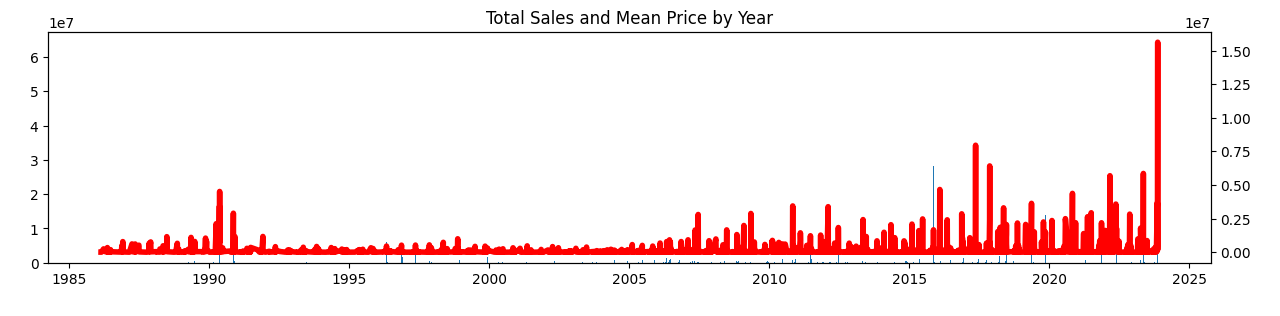

In [5]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR

sold_lots['Sale Date'] = pd.to_datetime(sold_lots['Sale Date'])

sales = pd.DataFrame(sold_lots.groupby('Sale Date')['Price (USD)'].sum())
sales['Total Sales'] = sold_lots.groupby('Sale Date')['Price (USD)'].sum()
sales['Mean Price'] = sold_lots.groupby('Sale Date')['Price (USD)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [6]:
# TOP ARTISTS BY SALES COUNT

# dataframe with 2 columns: #sales, total sales ($) and mean price ($)
top_artists = pd.DataFrame(sold_lots['Artist'].value_counts())
top_artists['Total Sales'] = sold_lots.groupby('Artist')['Price (USD)'].sum()
top_artists['Mean Price'] = sold_lots.groupby('Artist')['Price (USD)'].mean()
# include mean area
top_artists['Mean Area'] = sold_lots.groupby('Artist')['Area (cm²)'].mean()
# mean price per area
top_artists['Mean Price per Area'] = top_artists['Mean Price'] / top_artists['Mean Area']

top_artists = top_artists.sort_values(by='Total Sales', ascending=False)
top_artists.drop('Mean Area', axis=1, inplace=True)
top_artists.head()

,count,Total Sales,Mean Price,Mean Price per Area
Artist,,,,
Marc Chagall,13016,1.855106e+09,142525.011601,44.337617
Victor Vasarely,4750,1.330047e+08,28000.986947,4.608518
Cândido Portinari,174,1.885469e+07,108360.275862,42.654751
Emiliano Di Cavalcanti,241,1.729499e+07,71763.443983,22.366506
Vicente do Rego Monteiro,28,9.072210e+05,32400.750000,11.721355


In [7]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (USD)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 4750 lots for Victor Vasarely


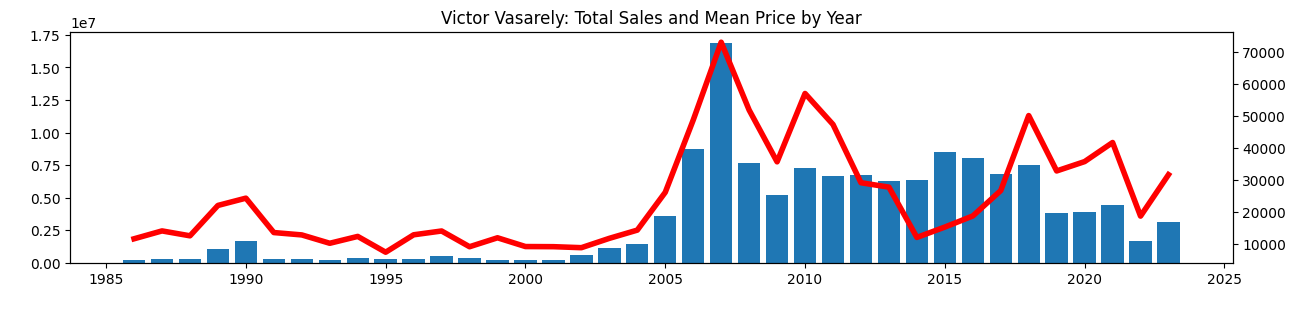

In [8]:
artist_name = 'Victor Vasarely'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (USD)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (USD)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (USD)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, f'{artist_name}: Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [9]:
lots['Medium_type'].value_counts()

Medium_type
print       10149
painting     3394
drawing      2860
other        1807
Name: count, dtype: int64

In [10]:
print('lots: ',len(lots))
lots_to_model = lots.copy()

lots_to_model = lots_to_model[lots_to_model['Medium_type'] != 'Other']
print('lots after filtering out "other" medium_type',len(lots_to_model))

percentil =  0.05
lots_to_model = lots_to_model[lots_to_model['Price (USD)'] > lots_to_model['Price (USD)'].quantile(percentil)]
lots_to_model = lots_to_model[lots_to_model['Price (USD)'] < lots_to_model['Price (USD)'].quantile(1-percentil)]
print('lots after filtering out price outliers', len(lots))

lots_to_model = lots_to_model[['Artist', 'Width (cm)', 'Height (cm)', 'Year', 'Year of sale', 'Price (USD)', 'Medium_type']].dropna()
print('lots for model (after dropna):', len(lots_to_model))

lots:  18210
lots after filtering out "other" medium_type 18210
lots after filtering out price outliers 18210
lots for model (after dropna): 11914


In [11]:
## FIT PRICE MODELS

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

X = lots_to_model.drop(['Price (USD)'], axis=1)
y = lots_to_model['Price (USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Medium_type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Medium_type'], drop_first=True)

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# function that fits all models and put metrics into a dataframe
# the function returns the dataframe and a dictionary with the models
def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,0.390438,0.455235,0.681401,0.625209
RMSE,62696.936619,59270.952914,45327.267429,49162.269900
MAE,35337.476194,23282.013581,19791.672946,24290.118577


In [12]:
## SAVE LOCALLY MODEL AND X_TEST

# save model to models folder
model = models['Random Forest']
with open('./models/artsy_auctions_rf_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# save X_test as csv
X_test.to_csv('./models/artsy_auctions_X_test.csv', index=False)